In [1]:
# 🛠️ 1. Setup
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

# 📦 Ensure data is downloaded and transform is applied
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 📥 Load the EuroSAT dataset
dataset = datasets.EuroSAT(root="./data", transform=transform, download=True)

# Get class labels
class_names = dataset.classes
print("EuroSAT Classes:", class_names)


EuroSAT Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [2]:
# 📊 2. Basic Info
print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(class_names)}")

Total number of images: 27000
Number of classes: 10


In [3]:
# 📈 3. Count number of images per class
labels = [dataset[i][1] for i in range(len(dataset))]
label_counts = Counter(labels)

# Convert to readable format
class_counts = {class_names[i]: label_counts[i] for i in range(len(class_names))}
for cls, count in class_counts.items():
    print(f"{cls:20s}: {count} images")


AnnualCrop          : 3000 images
Forest              : 3000 images
HerbaceousVegetation: 3000 images
Highway             : 2500 images
Industrial          : 2500 images
Pasture             : 2000 images
PermanentCrop       : 2500 images
Residential         : 3000 images
River               : 2500 images
SeaLake             : 3000 images


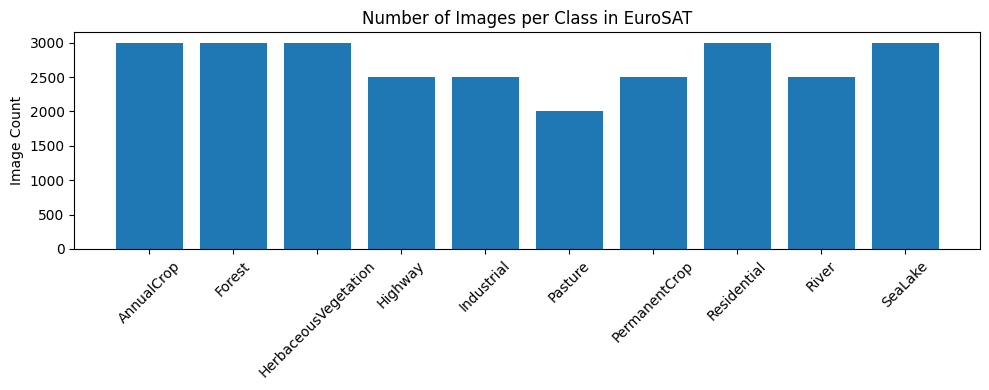

In [4]:
# 📉 Optional: Visualize counts as a bar chart
plt.figure(figsize=(10, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of Images per Class in EuroSAT")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


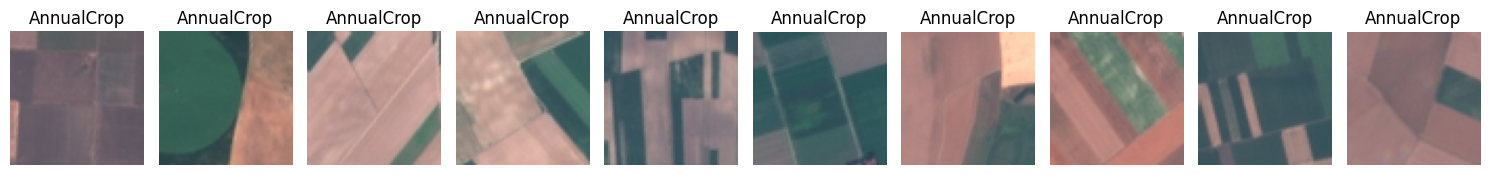

In [5]:
# 🖼️ 4. Show Sample Images
def show_images(dataset, num_images=10):
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert [C,H,W] to [H,W,C]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(dataset, num_images=10)


In [6]:
# 🔍 5. Inspect Image Tensor
img_tensor, label = dataset[0]
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label index: {label} ({class_names[label]})")
print(f"Min/Max pixel value: {img_tensor.min():.2f}, {img_tensor.max():.2f}")


Image tensor shape: torch.Size([3, 64, 64])
Label index: 0 (AnnualCrop)
Min/Max pixel value: 0.32, 0.80
